In [ ]:
pip install joblib
pip install matplotlib
pip install pandas
pip install scikit-learn
pip install numpy
pip install librosa
pip install wave
pip install noisereduce
pip install tqdm

In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np

import librosa # wav파일 MFCC 추출
import wave # raw to wav
import noisereduce as nr # 노이즈 감쇄 라이브러리

from tqdm import tqdm # 프로그레스 바 생성
from sklearn import svm # 모델
from sklearn.preprocessing import MinMaxScaler # 스케일러
from sklearn.decomposition import PCA # 주성분 분석
from sklearn.model_selection import cross_val_score # 교차검증

# 1. 경로 설정

In [2]:
# train data 파일이름
train_ctl_path = './fmcc_train.ctl'
# train data .wav 파일 저장 디렉토리 경로
train_data_dir = './raw16k/train/'

# test data 파일이름
test_ctl_path = './fmcc_eval.ctl'
# test data .wav 파일 저장 디렉토리 경로
test_data_dir = './eval/'

# 2. 학습 / 테스트 데이터 읽어오기

In [3]:
# .ctl 파일 입력 함수
def read_ctl_file(file_path):
    with open(file_path, 'r') as f:
        file_list = f.read().splitlines()
    return file_list

# 데이터 리스트 읽어오기
train_list = read_ctl_file(train_ctl_path) 
test_list = read_ctl_file(test_ctl_path)

In [5]:
test_list

['fmcc_eval_0001',
 'fmcc_eval_0002',
 'fmcc_eval_0003',
 'fmcc_eval_0004',
 'fmcc_eval_0005',
 'fmcc_eval_0006',
 'fmcc_eval_0007',
 'fmcc_eval_0008',
 'fmcc_eval_0009',
 'fmcc_eval_0010',
 'fmcc_eval_0011',
 'fmcc_eval_0012',
 'fmcc_eval_0013',
 'fmcc_eval_0014',
 'fmcc_eval_0015',
 'fmcc_eval_0016',
 'fmcc_eval_0017',
 'fmcc_eval_0018',
 'fmcc_eval_0019',
 'fmcc_eval_0020',
 'fmcc_eval_0021',
 'fmcc_eval_0022',
 'fmcc_eval_0023',
 'fmcc_eval_0024',
 'fmcc_eval_0025',
 'fmcc_eval_0026',
 'fmcc_eval_0027',
 'fmcc_eval_0028',
 'fmcc_eval_0029',
 'fmcc_eval_0030',
 'fmcc_eval_0031',
 'fmcc_eval_0032',
 'fmcc_eval_0033',
 'fmcc_eval_0034',
 'fmcc_eval_0035',
 'fmcc_eval_0036',
 'fmcc_eval_0037',
 'fmcc_eval_0038',
 'fmcc_eval_0039',
 'fmcc_eval_0040',
 'fmcc_eval_0041',
 'fmcc_eval_0042',
 'fmcc_eval_0043',
 'fmcc_eval_0044',
 'fmcc_eval_0045',
 'fmcc_eval_0046',
 'fmcc_eval_0047',
 'fmcc_eval_0048',
 'fmcc_eval_0049',
 'fmcc_eval_0050',
 'fmcc_eval_0051',
 'fmcc_eval_0052',
 'fmcc_eval_

# 3. RAW To WAV 파일 변환 // wave 라이브러리 사용
   - .wav 파일은 .raw 파일 경로에 저장

In [4]:
# Train
for file_name in tqdm(train_list):
    file_path = os.path.join(train_data_dir, file_name)
    with open(file_path + '.raw', "rb") as inp_f:
        data = inp_f.read()
        with wave.open(file_path + '.wav', "wb") as out_f:
            out_f.setnchannels(1)
            out_f.setsampwidth(2) # number of bytes
            out_f.setframerate(16000)
            out_f.writeframesraw(data)

# Test
for file_name in tqdm(test_list):
    file_path = os.path.join(test_data_dir, file_name)
    with open(file_path + '.raw', "rb") as inp_f:
        data = inp_f.read()
        with wave.open(file_path + '.wav', "wb") as out_f:
            out_f.setnchannels(1)
            out_f.setsampwidth(2) # number of bytes
            out_f.setframerate(16000)
            out_f.writeframesraw(data)

100%|███████████████████████████████████████| 900/900 [00:00<00:00, 5702.33it/s]


# 4. 특징추출

## 4.1. Mel-Spectrogram 특징 추출

In [6]:
def extract_log_mfcc(file_path):
    data,sr = librosa.load(file_path, sr=16000)
    # 노이즈 감쇄
    data = nr.reduce_noise(y=data, sr=sr)
    # Mel-Spectrogram 추출
    S =  librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000)
    # MFCC 추출
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=100)
    # 데이터 패딩
    pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    padded_mfcc = pad2d(mfcc, 100)
    return padded_mfcc

In [7]:
train_dataset = np.zeros(shape=(10000, 2), dtype=object)
test_dataset = np.zeros(shape=(900, 2), dtype=object)

In [8]:
# Train
i = 0
for file_name in tqdm(train_list):
    file_path = os.path.join(train_data_dir, file_name)
    audio_path = file_path + '.wav'
    # MEL 특징 추출
    mels = extract_log_mfcc(audio_path) 
    train_dataset[i, 0] = mels
    # 파일명에서 성별 label 추출
    file_info = file_name.split("/")[-1]
    prefix, _ = file_info.split("_")
    train_dataset[i, 1] = prefix[0]
    i += 1

100%|█████████████████████████████████████| 10000/10000 [07:20<00:00, 22.71it/s]


In [9]:
# Test
i = 0
for file_name in tqdm(test_list):
    file_path = os.path.join(test_data_dir, file_name)
    audio_path = file_path + '.wav'
    # MFCC 특징 추출
    mels = extract_log_mfcc(audio_path)
    feature = mels
    test_dataset[i, 0] = feature
    i += 1

100%|█████████████████████████████████████████| 900/900 [00:34<00:00, 26.05it/s]


## 4.2 데이터셋 저장

In [11]:
np.save("./dataset_train", train_dataset, allow_pickle=True)
np.save("./dataset_test", test_dataset, allow_pickle=True)

## 4.2 데이터 전처리

In [12]:
# 데이터 불러오기
train_data = pd.DataFrame(np.load("./dataset_train.npy",allow_pickle= True))
test_data = pd.DataFrame(np.load("./dataset_test.npy",allow_pickle= True))

In [13]:
# 데이터 컬럼 설정
train_data.columns = ['feature', 'label']
test_data.columns = ['feature', 'label']

In [14]:
print(train_data.info())
print(train_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  10000 non-null  object
 1   label    10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB
None
(10000, 2)


In [15]:
# 넘파이 배열로 변환
X_train = np.array(train_data.feature.tolist())
y_train = np.array(train_data.label.tolist())
X_test = np.array(test_data.feature.tolist())
y_test = np.array(test_data.label.tolist())

In [16]:
print('X_train, y_train 데이터')
print(X_train.shape)
print('X_test, y_test 데이터')
print(X_test.shape)

X_train, y_train 데이터
(10000, 100, 100)
X_test, y_test 데이터
(900, 100, 100)


In [17]:
# 차원 Reshape
nsamples1, nx1, ny1 = X_train.shape
X_train = X_train.reshape((nsamples1,nx1*ny1))
nsamples2, nx2, ny2 = X_test.shape
X_test = X_test.reshape((nsamples2,nx2*ny2))

In [18]:
print('RESHAPE\n X_train, y_train 데이터')
print(X_train.shape)
print(y_train.shape)
print('X_test, y_test 데이터')
print(X_test.shape)
print(y_test.shape)

RESHAPE
 X_train, y_train 데이터
(10000, 10000)
(10000,)
X_test, y_test 데이터
(900, 10000)
(900,)


### 학습데이터에 맞게 학습/테스트 데이터 스케일링

In [19]:
# 스케일링 - MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# 데이터 셔플
idx = np.arange(X_train_scaled.shape[0])
np.random.shuffle(idx)
X = X_train_scaled[idx]
y = y_train[idx]

In [21]:
print('데이터 셔플 확인')
print(y[:10])

데이터 셔플 확인
['F' 'M' 'M' 'F' 'M' 'F' 'F' 'F' 'M' 'F']


In [22]:
# 데이터 라벨 인코더
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y = lb.fit_transform(y)
y_test = lb.fit_transform(y_test)

In [23]:
print('데이터 라벨 인코딩 확인')
print(y[:10])
print('\nSHAPE 확인\nX_train, y_train 데이터')
print(X.shape)
print(y.shape)
print('X_test, y_test 데이터')
print(X_test.shape)
print(y_test.shape)

데이터 라벨 인코딩 확인
[0 1 1 0 1 0 0 0 1 0]

SHAPE 확인
X_train, y_train 데이터
(10000, 10000)
(10000,)
X_test, y_test 데이터
(900, 10000)
(900,)


## 4.3. 데이터 시각화 및 분석

In [24]:
# 학습 데이터
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# 주성분으로 이루어진 데이터 프레임 구성

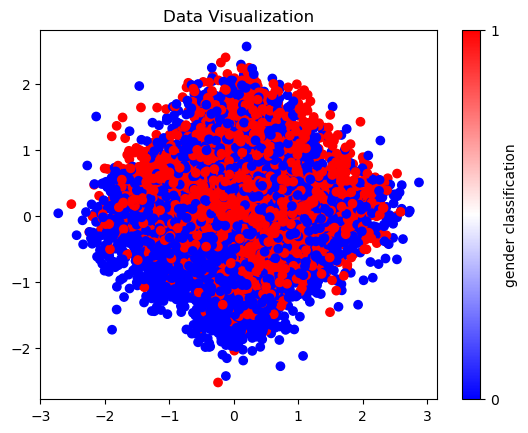

In [25]:
plt.scatter(np.array(principalDf)[:, 0], np.array(principalDf)[:, 1], c=y, cmap='bwr')
plt.title('Data Visualization')
plt.colorbar(ticks=[0, 1], label='gender classification')
plt.show()

In [26]:
# 테스트 데이터
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(X_test)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# 주성분으로 이루어진 데이터 프레임 구성

/var/folders/nk/wf8xl72x1nj4zqkpjtmw6cc00000gn/T/ipykernel_62849/817099317.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.array(principalDf)[:, 0], np.array(principalDf)[:, 1], cmap='bwr')


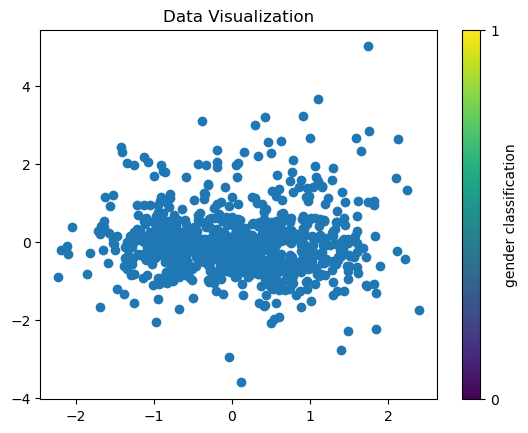

In [27]:
plt.scatter(np.array(principalDf)[:, 0], np.array(principalDf)[:, 1], cmap='bwr')
plt.title('Data Visualization')
plt.colorbar(ticks=[0, 1], label='gender classification')
plt.show()

# 5. 모델 학습 및 테스트
   
### Train Data : X, y
### Test Data : X_test, y_test

In [20]:
# 사용 모델 / sklrean의 비선형 SVM
# GridSearch CV로 파악 / C = 10, gamma = 0.025
svm_model = svm.SVC(kernel='rbf',
                    C=10, 
                    gamma=0.025, 
                    random_state=24)

In [21]:
# 모델학습 및 정확도 측정
svm_model.fit(X,y)
print('모델 정확도: ', round(svm_model.score(X_test, y_test), 6))

모델 정확도:  0.955556


In [24]:
# 교차검증 cv = 4
score = cross_val_score(svm_model, X, y, cv=4)
print('\n교차 검증 점수 = ', score)
print('교차 점수 평균 = ', np.mean(score))


교차 검증 점수 =  [0.9672 0.9688 0.9632 0.9664]
교차 점수 평균 =  0.9664


In [ ]:
# 모델 학습 곡선 그리기
train_sizes = [2000, 4000, 6000, 8000, 10000]  # 트레이닝 

train_scores = []
test_scores = []

for size in train_sizes:
    # 학습 데이터에서 subset 추출
    X_train_subset = X[:size]
    y_train_subset = y[:size]

    # 모델 학습
    svm_model.fit(X_train_subset, y_train_subset)

    # 학습 데이터 예측
    train_score = svm_model.score(X_train_subset, y_train_subset)
    train_scores.append(train_score)

    # 테스트 데이터 예측
    test_score = svm_model.score(X_test, y_test)
    test_scores.append(test_score)

# 러닝 커브 그리기
plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores, 'o-', color="g", label="Test Score")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# 모델 저장

In [29]:
# 모델 저장
joblib.dump(svm_model, './svm_model_기하하학.pkl')

['./svm_model_(95.22).pkl']

## 참고사항 : GridSearch 추가 코드 (실행 X)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

## Step1. 모델의 선언
svc_grid = svm.SVC()
 
## 튜닝에 사용할 파라미터 나열
param_grid = {
    'C': [1, 5, 10, 30, 50]
    , 'kernel':['poly', 'rbf']
    , 'gamma' :[0.01, 0.025, 0.5, 0.1, 0.5, 1, 10]
}
 
## KFold Cross Validation을 통한 모델 퍼포먼스 보증
kf = KFold(random_state = 64
          , n_splits = 4
          , shuffle = True)

## Grid Search 모델의 선언
grid_search = GridSearchCV(estimator = svc_grid
                        , param_grid = param_grid
                        , cv = kf
                        , verbose = 1
                        )
 
## Grid Search를 활용한 학습 진행 
grid_search.fit(X, y)

In [ ]:
print("파라미터 : ", grid_search.best_params_)
print("예측 정확도 : {:.4f}".format(grid_search.best_score_))